In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from functools import partial

from matplotlib import pyplot as plt

In [15]:
w      = np.diag([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
q_real = np.array([1,2,3, 5, 6, 4])

In [17]:
#scalar product with weights
def dot_w(a, b, w, q):
    return sum([a(q_) * b(q_) * w[i, i] for i, q_ in enumerate(q)])

In [18]:
class OrthoPolyRef:
    
    def __init__(self, parent_set, i):
        self.parent_set = parent_set
        self.i          = i
    
    def __call__(self, q):
        if isinstance(q, (list,tuple,np.ndarray)):
            return np.array([self.parent_set.get_result(self.i, q_) for q_ in q])
        
        return self.parent_set.get_result(self.i, q)
    
class OrthoPolyBase:
    
    def __init__(self, q, w, order):
        self.q_real = q
        self.w      = w
        
        self.order  = order
        
        self.a      = [np.nan] * (order + 1)
        self.b      = [np.nan] * (order + 1)
        self.c      = [np.nan] * (order + 1)
        
        self.cache  = { }
        
        self._calculate_initial_state ()
        self._calculate_params ()
    
    def _calculate_initial_state (self):
        q_min, q_max = self.q_real.min(), self.q_real.max()
        self.q = 2 * self.q_real / (q_max - q_min) - (q_max + q_min) / np.abs(q_max - q_min)
        
        self.b[0] = np.sqrt(w.sum())
        self.c[0] = 1 / self.b[0]
        
        for q in self.q:
            self.cache[(0, q)] = self.c[0]
    
    def _calculate_params(self):
        for i in range(0, self.order):
            qP = lambda q: q * self[i](q)
            P  = self
            
            a = dot_w(P[i], qP, w, self.q)
            c = 1 / np.sqrt( dot_w(qP, qP, w, self.q) - a**2 - (b**2 if i > 0 else 0) )
            b = 1 / c
            
            self.a[i+1] = a
            self.b[i+1] = b
            self.c[i+1] = c
            
            for q in self.q:
                self.cache[(i+1, q)] = c * ((q-a) * P[i](q) - (self.b[i] * P[i-1](q) if i > 0 else 0))
    
    def _calculate_result(self, i, q):
        P  = self
        
        if i == 0:
            return self.cache[(0, 1.0)]
        
        return self.c[i] * ((q - self.a[i]) * P[i-1](q) - (self.b[i-1] * P[i-2](q) if i > 1 else 0))
    
    def get_result(self, i, x):
        #cache the q points
        if x in self.q_real:
            if (i, x) not in self.cache:
                self.cache[(i, x)] = self._calculate_result(x)
            
            return self.cache[(i, x)]
        else:
            return self._calculate_result(i, x)
    
    def __getitem__(self, order):
        return OrthoPolyRef(self, order)

In [19]:
base = OrthoPolyBase(q_real, w, 3)

## Tests

#### 0. order cached

In [20]:
base[0](1)

1.0000000000000002

#### 0. order non-cached

In [21]:
base[0](0.12345346724727)

1.0000000000000002

#### 1. order cached

In [22]:
base[1](1)

1.4638501094227996

#### 1. order non-cached

In [23]:
base[1](0.12345346724727)

0.18071737153854006

#### Cache

In [24]:
base.cache

{(0, -0.9999999999999999): 1.0000000000000002,
 (0, -0.5999999999999999): 1.0000000000000002,
 (0, -0.19999999999999996): 1.0000000000000002,
 (0, 0.6000000000000001): 1.0000000000000002,
 (0, 1.0): 1.0000000000000002,
 (0, 0.20000000000000018): 1.0000000000000002,
 (1, -0.9999999999999999): -1.4638501094227998,
 (1, -0.5999999999999999): -0.8783100656536799,
 (1, -0.19999999999999996): -0.2927700218845601,
 (1, 0.6000000000000001): 0.8783100656536799,
 (1, 1.0): 1.4638501094227996,
 (1, 0.20000000000000018): 0.2927700218845601,
 (2, -0.9999999999999999): 1.3363062095621219,
 (2, -0.5999999999999999): -0.267261241912425,
 (2, -0.19999999999999996): -1.0690449676496983,
 (2, 0.6000000000000001): -0.2672612419124246,
 (2, 1.0): 1.3363062095621219,
 (2, 0.20000000000000018): -1.0690449676496983,
 (3, -0.9999999999999999): -0.9128709291752771,
 (3, -0.5999999999999999): 1.2780193008453875,
 (3, -0.19999999999999996): 0.7302967433402215,
 (3, 0.6000000000000001): -1.2780193008453873,
 (3, 1

#### Polynomials

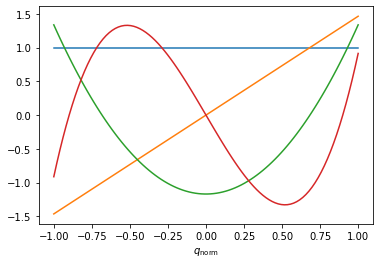

In [25]:
x=np.linspace(-1, 1, 100)

for i in range(4):
    plt.plot(x, base[i](x))

plt.xlabel("$q_{\mathrm{norm}}$");